# Project: ML - KNN, Multivariate LR (Predicting House Sale Prices)

<br>

## Questions to address:
- Predict house prices using a linear regression ML algorithm
- The sklearn LR model (using OLS) gives the best results

<br>

## Tools:
- Models: 
  - KNN model: algorithm = auto, p = 2 (euclidean distance), rmse as metric
  - sklearn Multivariate LR (using Ordinary Least Squares)
  - Multivariate LR with Ordinary Least Squares coded direcly
- Feature Preparation, Selection and Engineering
  - transforming and processing:
    - drop columns that leak information about target column
    - remove columns with more than 25% missing values
    - replace NaNs with mean from other rows
    - combine some features into new ones
    - dummy coding for categorical features
      - transform numerical to categorical (for those where numbers have no meaning)
      - identify text columns to make categorical:
        - only those with only a few unique values
        - remove low varianve columns (more than 95% of the values are the same)      
      - deal with NaNs, then dummy code  
  - feature selection
    - manual process:
      - ignore categoric columns for now
      - calculate correlations and select strongly correlated
      - generate sns.heatmap to check any correlations between variables
    - automated process:
      - using SelectKBest  
  
- Holdout and K-fold Validation
- Holdout and K-fold predictions

<br>

### load defaults

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: House properties and price

In [4]:
df = pd.read_csv('./data/AmesHousing.txt', delimiter='\t')
display(df.iloc[:3,[0,1,2,3,4,5,6,7,8,9,10,11,12,-1]])

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,172000


<br>

### Feature Preparation, Selection and Engineering <br>
### transforming and processing:
- drop columns that leak information about target column
- remove columns with more than 25% missing values
- replace NaNs with mean from other rows
- combine some features into new ones
- dummy coding for categorical features
  - transform numerical to categorical (for those where numbers have no meaning)
  - identify text columns to make categorical:
    - only those with only a few unique values
    - remove low varianve columns (more than 95% of the values are the same)      
  - deal with NaNs, then dummy code  

In [5]:
def transform_features(df):
    new_df = df.copy()
    
    #remove columns that leak information about target  + PID
    to_drop = ['PID','Order', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']
    new_df.drop(to_drop,axis=1, inplace=True)
    
    #drop cols with more than 25% NaNs
    null_count = df.isnull().sum()
    null_cols = null_count[null_count>0.25*len(new_df)].index 
    new_df.drop(null_cols,axis=1, inplace=True)
    
    #replace NaNs in numeric null columns with mean
    null_count = new_df.isnull().sum()
    null_cols = null_count[null_count>0].index    
    float_cols = new_df.select_dtypes(include=['float']).columns
    new_df[float_cols] = new_df[float_cols].fillna(new_df[float_cols].mean())
            
    #create new columns age and age since remodulation
    new_df['Age'] = 2017 - new_df['Year Built']
    new_df['Age Since Remod'] = 2017 - new_df['Year Remod/Add']
    new_df['Remod Age'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['GarageAge'] = 2017 - new_df['Garage Yr Blt']
    new_df.drop(['Year Built', 'Year Remod/Add', 'Garage Yr Blt'],axis=1, inplace=True)    
            
    #TRANSFORM TO CATEGORIC    
    #Identify numerical columns that should be categoric or transformed     
    #text_cols = new_df.select_dtypes(include=['int64','float64']).columns
    #for col in text_cols:
    #    print(col)
    #    print(new_df[col].iloc[0:9])
    
    #change numeric to str to make categorical
    new_df['MS SubClass'] = new_df['MS SubClass'].astype(str)          
     
    ###Identify text columns to make categorical 
    text_cols = new_df.select_dtypes(include=['object']).columns
    for col in text_cols:           
        #drop large number of categories >10
        if(len(new_df[col].unique())>10):
            new_df.drop(col,axis=1, inplace=True)
        else:
            #drop low variance (more than 95% in one cat)
            counts = new_df[col].value_counts()
            if(counts[0]>0.95*len(new_df[col])):
                new_df.drop(col,axis=1, inplace=True)  
            
    #Deal with remaining text nulls before dummy coding    
    null_count = new_df.isnull().sum()
    null_cols = null_count[null_count>0].index   
    #print(new_df[null_cols].info()) 
    #basement and garage descriptions have nulls(for houses without either)
    #large number of Nans in garage conditions and probably little influence on price: drop 
    garage_cols_to_drop = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
    new_df.drop(garage_cols_to_drop,axis=1, inplace=True)
    #drop reamining nulls (basement condition rows)
    new_df.dropna(axis=0, inplace=True)
              
    #DUMMY CODING    
    text_cols = new_df.select_dtypes(include=['object']).columns    
    for col in text_cols:             
        new_df[col] = new_df[col].astype('category')   
        dummy_cols = pd.get_dummies(new_df[col])    
        new_df = pd.concat([new_df, dummy_cols], axis=1)
        new_df.drop(col, inplace=True, axis=1)  
              
    
    return new_df

<br>

### feature selection
- manual process:
  - ignore categoric columns for now
  - calculate correlations and select strongly correlated
  - generate sns.heatmap to check any correlations between variables
- automated process:
  - using SelectKBest

manual process

['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', '1st Flr SF', 'Total Bsmt SF', 'Full Bath', 'Age', 'Age Since Remod', 'GarageAge', 'Mas Vnr Area', 'TotRms AbvGrd']
SalePrice          1.000000
Overall Qual       0.796835
Gr Liv Area        0.710544
Garage Cars        0.650806
Garage Area        0.640152
1st Flr SF         0.634436
Total Bsmt SF      0.634317
Full Bath          0.555083
Age                0.554400
Age Since Remod    0.525825
GarageAge          0.511855
Mas Vnr Area       0.506103
TotRms AbvGrd      0.505792
Name: SalePrice, dtype: float64


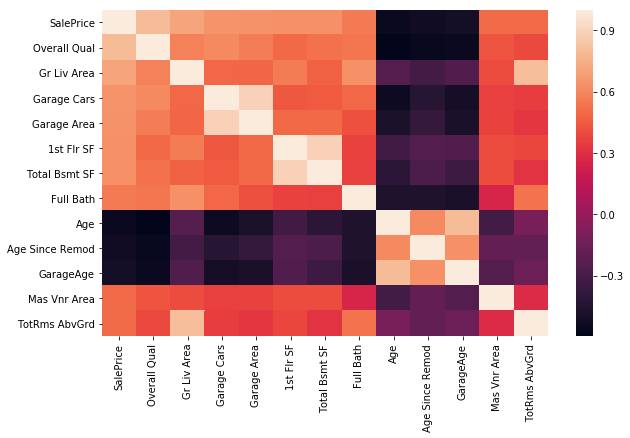

In [6]:
new_df = transform_features(df)

#ignore categorical columns for now ('uint8')
num_cols = new_df.select_dtypes(include=['int64','float64']).columns  

corrmat = new_df[num_cols].corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values(ascending=False)
strong_corrs = sorted_corrs[sorted_corrs>0.5].index.tolist()
print(strong_corrs)
print(sorted_corrs[sorted_corrs>0.5])

plt.figure(figsize=(10,6))
sns.heatmap(new_df[strong_corrs].corr())
plt.show()

#from strongly correlated variables choose the one with highest correlation to sale price
#'Garage Cars' and 'Garage Area': Garage Cars
#'1st Flr SF' and 'Total Bsmt SF': 1st Flr SF
#'Age', and 'GarageAge': Age
selected_features_manual = ['SalePrice','Overall Qual', 'Gr Liv Area', 'Garage Cars', '1st Flr SF', 
                            'Full Bath', 'Age', 'Age Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd']

<br>

**Automated feature selection with SelectKBest**

In [11]:
new_df = transform_features(df)

num_cols = new_df.select_dtypes(include=['int64']).drop(['SalePrice'], axis = 1).columns 
X = new_df[num_cols].values
Y = new_df['SalePrice'].values

test = SelectKBest(score_func=f_regression, k=5)
fit = test.fit(X, Y)
print("selected features:")
print(num_cols[test.get_support()].tolist())
#selected_features_automated = ['SalePrice','Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Age']

# summarize scores
np.set_printoptions(precision=3)
print("\nfit scores")
print(fit.scores_)

selected features:
['Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Age']

fit scores
[2.262e+02 4.905e+03 3.960e+01 1.900e+03 2.127e+02 4.159e+00 2.875e+03
 1.256e+03 2.314e+02 5.613e+01 2.470e+01 9.694e+02 7.973e+02 3.257e+02
 2.820e+02 5.097e+01 3.081e+00 3.742e+01 1.613e+01 4.861e-01 1.251e+03
 1.078e+03 1.833e+02]


In [12]:
def select_features(df, selection_process):
    selected_features_manual = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', '1st Flr SF', 
                                'Full Bath', 'Age', 'Age Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd']
    selected_features_automated = ['SalePrice','Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Age']

    if(selection_process == 'manual'):
        cols_to_keep = selected_features_manual
    else:
        cols_to_keep = selected_features_automated
    #cols_to_keep = df.select_dtypes(include=['int64','float64']).columns  
    #cols_to_keep = df.select_dtypes(include=['uint8', 'int64','float64']).columns      
    #cols_to_keep = ['Age', 'SalePrice'] 
    
    return df[cols_to_keep]

<br>

### Validation:
- implement simple cross validation
  - train model on train and test on test
  - train model on test and test on train
- implement k-fold cross valiation

In [57]:
def train_and_test(train, test, cv_type='simple'):  
    if(cv_type != 'kfold'):
        cv_type = 'simple'
       
    features = train.columns.drop('SalePrice')
      
    if(cv_type=='simple'):        
        knn = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)
        knn.fit(train[features], train['SalePrice'])
        predictions = knn.predict(test[features])
        rmse_1 = (np.sqrt(mean_squared_error(test['SalePrice'],predictions)))
        
        knn = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)
        knn.fit(test[features], test['SalePrice'])
        predictions = knn.predict(train[features])
        rmse_2 = (np.sqrt(mean_squared_error(train['SalePrice'],predictions)))
        
        print("RMSE on training set = {:0.2f} \nRMSE on test set = {:0.2f}".format(rmse_1, rmse_2))
        
        return predictions
    
    else:   
        df = pd.concat([train,test],axis=0)
       
        rmse_mean_list=[]    
        rmse_std_list=[]
        num_folds = np.linspace(3,100,20).astype(int)          
        for fold in num_folds:
            kf = KFold(fold, shuffle=True, random_state=1)
            model = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)           
            mses = cross_val_score(model, df[features], df['SalePrice'], scoring="neg_mean_squared_error", cv=kf)
            rmses = np.sqrt(np.absolute(mses))         
            rmse_mean_list.append(np.mean(rmses)) 
            rmse_std_list.append(np.std(rmses)) 
                        
        #plot
        error = np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2)   
        for idx, element in enumerate(error):            
            if((idx>2) & (idx<(len(error)-2))):                
                error[idx]=(error[idx-2]+error[idx-1]+error[idx]+error[idx+1]+error[idx+1])/5
                
        
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(num_folds, error)
            
        folds_array = np.array(num_folds)        
                
        ax.set_xlabel('kfolds'), ax.set_ylabel('error')
        ax.tick_params(right=False, top=False)    
        ax.spines['right'].set_visible(False) 
        ax.spines['top'].set_visible(False) 
        plt.show()
        
        
        kf = KFold(10, shuffle=True, random_state=1)
        model = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)
        predictions = cross_val_predict(model, df[features], df['SalePrice'], cv=kf)
        
        return predictions     

<br>

### Full Workflow for KNN model, holdout and k-fold valiation

Features used
['SalePrice', 'Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Age']

Simple Validation:
RMSE on training set = 44089.62 
RMSE on test set = 42773.32
[182752.8 125320.  159950.  336334.4 174700.  174700.  183480.  184220.
 235240. ]

K-fold Validation:


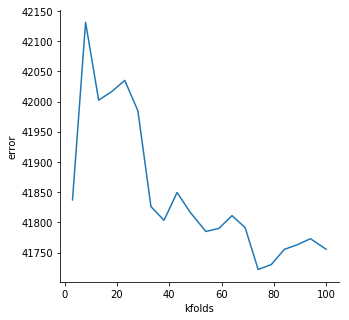

[185252.8 123600.  160350.  354254.4 182300.  188680.  193180.  193920.
 230400. ]


In [58]:
new_df = transform_features(df)
new_df = select_features(new_df, selection_process='automated')
print('Features used')
print(new_df.columns.tolist())

print('')
#print(new_df.info())
    
train = new_df[0:1460].copy()
test = new_df[1460:].copy()

print("Simple Validation:")
predictions = train_and_test(train,  test, cv_type='simple')
print(predictions[:9])

print("\nK-fold Validation:")
predictions = train_and_test(train,  test, cv_type='kfold')
print(predictions[:9])

<br>

### Full Workflow for Ordinary Least Squares using sklearn LR, holdout valiation

In [105]:
new_df = transform_features(df)
new_df = select_features(new_df, selection_process='automated')

train = new_df[0:1460].copy()
test = new_df[1460:].copy()

features = train.columns.drop('SalePrice')

model = LinearRegression()
model.fit(train[features], train['SalePrice'])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

target = 'SalePrice'
train_rmse = np.sqrt(np.abs(mean_squared_error(train[target], train_predictions)))
test_rmse = np.sqrt(np.abs(mean_squared_error(test[target], test_predictions)))

print("RMSE on training set = {:0.2f} \nRMSE on test set = {:0.2f}".format(train_rmse, test_rmse))

RMSE on training set = 36388.94 
RMSE on test set = 39107.20


better results with LR model

<br>

### Full Workflow for Ordinary Least Squares (coded), holdout valiation

In [109]:
new_df = transform_features(df)
new_df = select_features(new_df, selection_process='automated')

train = new_df[0:1460].copy()
test = new_df[1460:].copy()

features = train.columns.drop('SalePrice')

X = train[features]
y = train['SalePrice']

a = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)), np.transpose(X)), y)
print(a)

train_predictions = train[features[0]]*a[0]
test_predictions = test[features[0]]*a[0]
for ii in range(1, len(a)):
    train_predictions += train[features[ii]]*a[ii]
    test_predictions += test[features[ii]]*a[ii]

target = 'SalePrice'
train_rmse = np.sqrt(np.abs(mean_squared_error(train[target], train_predictions)))
test_rmse = np.sqrt(np.abs(mean_squared_error(test[target], test_predictions)))

print("RMSE on training set = {:0.2f} \nRMSE on test set = {:0.2f}".format(train_rmse, test_rmse))

[ 17759.23      40.312     54.866 -12930.478   -780.377]
RMSE on training set = 37070.10 
RMSE on test set = 40137.60
